**CONV + CONV + attention**

**В данном ноутбуке рассматривается рассмотренный ранее метод encoder conv1d + decode conv1d c механизмом attention с использованием предобученных embeddings (в ноутбуке lab2_convolution_position.ipynb).**



In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [ ]:
%load_ext autoreload
%autoreload 1
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time
import numpy as np
import pickle

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)


TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.82, 0.15, 0.03], random_state = random.seed(23))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 41000
Number of validation examples: 1500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9427
Unique tokens in target (en) vocabulary: 6777


In [ ]:
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")

In [ ]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")
import utils
import convolution_pos
import pipeline_func
import imp
imp.reload(utils)
imp.reload(convolution_pos)
imp.reload(pipeline_func)
from  convolution_pos import *
from pipeline_func import *
from utils import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
embedding_pretrained = True

if embedding_pretrained:
    with open("/content/drive/MyDrive/MADE/semester2/NLP/cc.ru.300.vec.pickle", "rb") as file_ru:
        ru_emb = pickle.load(file_ru)
       

Не все слова, которые встречаются в текстах, есть среди pretrained. Это чаще всего имена собственные, города, страны и т.д. Решила, что лучше всего в этой ситуации сгенерировать новые случайные embeddings для этих слов

In [ ]:
ru_no_emb = {}
s = 0
for word in SRC.vocab.itos:
  s += 1
  if word not in ru_emb.vocab:
   # print(s)
    #ru_no_emb.update({word : [np.sin(s * np.pi/30 ) for i in range(300)]})
    ru_no_emb.update({word : [random.random() for i in range(300)]})

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

embedding_pretrained = True
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM, remove_emb_layer = True)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

300
512


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,828,347 trainable parameters


Обязательно сначала инициализируем слои , а потом уже инициализируем embedding слой

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6831, 300)
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_emb2hid): Linear(

In [ ]:
embedding_pretrained = True

if embedding_pretrained:
    with open("/content/drive/MyDrive/MADE/semester2/NLP/cc.ru.300.vec.pickle", "rb") as file_ru:
        ru_emb = pickle.load(file_ru)
       

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
ru_emb

In [ ]:
embedding_matrix = np.zeros((INPUT_DIM, EMB_DIM))

s = 0
for word in SRC.vocab.itos:
  if word in ru_emb.vocab:
    embedding_matrix[s] = ru_emb[word]
  s += 1  
print(embedding_matrix)

mask = (embedding_matrix[:, 0] == 0.0) # noninitialized vectors
mean, std = embedding_matrix[~mask].mean(), embedding_matrix[~mask].std()
print(mean, std)

s = 0
for word in SRC.vocab.itos:
  if word not in ru_emb.vocab:
    embedding_matrix[s] = np.random.normal(mean, std, 300) 
  s += 1

 # else:
 #   embedding_matrix[s] = np.random.normal(mean, std, 300)  
 # s += 1


#mask = (embedding_matrix[:, 0] == 0.0) # noninitialized vectors
#print(mask)
#mean, std = embedding_matrix[~mask].mean(), embedding_matrix[~mask].std()
#embedding_matrix[mask] = np.random.normal(mean, std, 300)  

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.0082     -0.0019      0.0387     ... -0.0283     -0.0678
  -0.0402    ]
 [ 0.0306      0.17110001  0.1129     ...  0.0351     -0.078
  -0.0653    ]
 [ 0.1874     -0.2309      0.13060001 ... -0.0752     -0.1841
  -0.0004    ]]
-0.000966656319825526 0.07744785945950566


In [ ]:
print(embedding_matrix)

[[ 0.07571209 -0.04323383  0.15588076 ...  0.08830916  0.02837885
  -0.00982365]
 [ 0.0099518  -0.04508099 -0.03624625 ... -0.02147023 -0.04770819
  -0.11715966]
 [ 0.11496558  0.08815015 -0.03888816 ... -0.04569351 -0.01663228
   0.0669666 ]
 ...
 [ 0.0082     -0.0019      0.0387     ... -0.0283     -0.0678
  -0.0402    ]
 [ 0.0306      0.17110001  0.1129     ...  0.0351     -0.078
  -0.0653    ]
 [ 0.1874     -0.2309      0.13060001 ... -0.0752     -0.1841
  -0.0004    ]]


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

EMBEDDING_NO = 0
EMBEDDING_WITHOUT_LAYER = 1
EMBEDDING_WITH_LAYER = 2

embedding_pretrained = EMBEDDING_WITH_LAYER
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM, embedding_matrix = embedding_matrix)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

***
111
300
512


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,833,155 trainable parameters


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        #print(name)
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
for param in model.encoder.tok_embedding.parameters():
   param.requires_grad = True

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.0001

#optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=0, last_epoch=-1, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

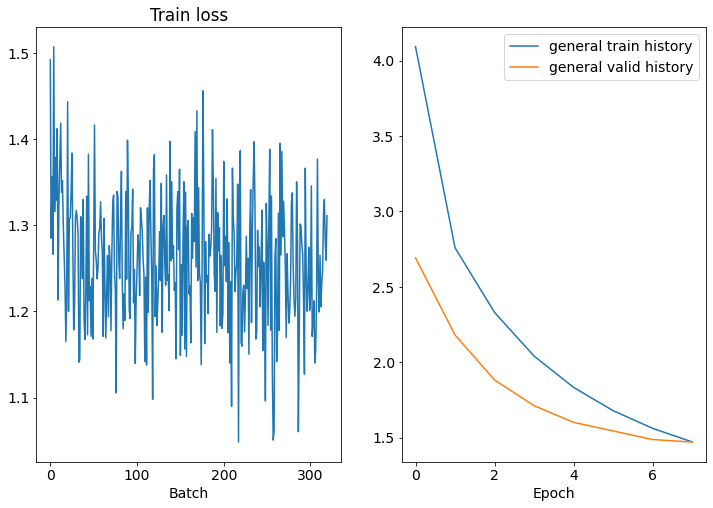

Epoch: 01 | Time: 0m 55s
	Train Loss: 1.261 | Train PPL:   3.529
	 Val. Loss: 1.400 |  Val. PPL:   4.055
CPU times: user 1min 5s, sys: 453 ms, total: 1min 5s
Wall time: 56 s


In [ ]:
%%time
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')
embedding_pretrained = EMBEDDING_WITH_LAYER

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, None, embedding_pretrained = embedding_pretrained) 
    valid_loss = evaluate(model, valid_iterator, criterion, embedding_pretrained = embedding_pretrained)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_state  = torch.load(("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_emb_bleu39.0_best.pt")
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.523 | Test PPL:   4.588 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_emb_no_freeze.pt")
           )     

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import utils
import imp
imp.reload(utils)
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        ##print(src)
        #print(trg)
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
     
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        #print(pred_trg)
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        

    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.54


**Bleu у лучшей модели среди мною рассмотренных получился всего 31.54**